Vision Transformer Model + Configuration and Metrics 👓
----------------------------

The ViT Model is based on the architecture of the Transformer introduced by Vaswani et al. in the article *Attention Is All You Need*. While the original Transformer is commonly used for NLP tasks, the ViT Model was implemented to work on images like with Convolution Neural Networks. The Transformer initially took a sequence of vectors converted to an embedding vector of fixed features' size before being added to a 1-dimensional positional vector which learned to identify the position of each element in the sequence. In the ViT Model, the series comprises the patches we define in the following notebook [preprocessing_and_loading](preprocessing_and_loading.ipynb). Each patch must be flattened for we obtain an input sequence of size $(N\times (D^2.C))$, where $N$ is the number of patches, D is the size of the height and width of the patches, and $C$ is the number of channels. 

To make transfer learning with the pre-trained model, the classification layer composed of two linear layers and a GeLU activation will take as enter the output of the encoder reshaped to $(batch\_size, Sequence\_size \times Model size)$ to give us a final output of $(batch\_size, number\_of\_labels)$. Only the weights of the classifier are randomly initialized to be trained on new images. 

Let us see the architecture and define what makes it different from the original Transformer architecture.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# importing some libraries
from fake_face_detection.data.fake_face_dataset import FakeFaceDetectionDataset
from transformers import ViTForImageClassification
from transformers import ViTFeatureExtractor
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from PIL import Image
import numpy as np
# import evaluate
import pickle
# import torch

# set a seed for all the following process
pl.seed_everything(0)


Global seed set to 0


0

### Architecture

The path or name of the ViT Model must be indicated to be loaded. We want to recuperate the base model pre-trained by Google on ImageNet21k's images of size $(224\times 224)$ and requiring $16$ patches. We need to indicate the following name: `google/vit-base-patch16-224-in21k`. We will also provide the number of labels which is `2` in our case, and we need to give the class Ids that we recuperated in [generate_an_visualize](generate_and_visualize.ipynb). 

In [2]:
model_name = 'google/vit-base-patch16-224-in21k'

# recuperate the images characteristics
with open('data/extractions/fake_real_dict.txt', 'rb') as f:
    
    depick = pickle.Unpickler(f)
    
    characs = depick.load()

# recuperate the model and print the configurations
vit_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 2,
    id2label = {name: key for key, name in characs['ids'].items()},
    label2id = characs['ids']
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We loaded above the main configurations of the ViT Model understanding:

- A `hidden size` or more commonly `d_model` of <i style = "color: orange">768</i> 

- A `number of features of the `Feed Forward Network` of <i style = "color: orange">3072</i>

- A `number of encoder and decoder layers` of <i style = "color: orange">12</i>

- No drop-out is used, and a convolution layer of <i style = "color: orange">3</i> input channels is used to provide the projection of the patches directly.

This version of the ViT Model uses the convolution layer to recuperate the projected version of the patches. We no longer need to split the images into patches and transform each linearly. The size of the convolution layer's output can be found as follows:

$Out\_Height = Out\_Width = \frac{(224 - 16)}{16} + 1 = 14$

And the number of channels of the convolution layer is equal to the `hidden size.` Then the number of channels of the images passes from $3 \rightarrow 768$. Including the number of channels, we obtain a final output size of $(14, 14, 768)$ for the embedding matrix. The embedding matrix is then transformed into a vector of dimension $(14 \times 14, 768)$ to add to a position embedding of the same size and fed into the ViT Model.

The id map that was provided earlier will be used to predict the test set.

The main differences between the original Transformer and the current Transformer are that the, later on, uses a convolution layer to obtain the projections, only an encoder stack is required, a pre-layer normalization is used in place of a post-layer normalization, a final `Multi-Layer Perceptron` (MLP) is added to classify the images from the outputs or state of the encoder and each feed-forward network use as activation function the `GeLU` in place of the `ReLU` activation. The `GeLU` activation can be approximated by

$$
GeLU(x) = 0.5x(1 + tanh[\sqrt{2\pi}(x + 0.044715x^3)])
$$

where $x$ is the input to the $GeLU$ activation. It provides a smoother function than the `ReLU.`

Let us display the whole architecture below.

In [3]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

### Attention

An attention matrix is provided by the Multi-head-attention of the last encoder layer and corresponds to the attention that was computed on each pixel of the image. It corresponds to two main series of concatenations between sub-attentions calculated inside the Multi-Head Attentions. Inside each Multi-Head Attention, we have Self-attention, which takes some linear transformations from the input sequence: the queries $q$, the values $v$, and the keys $k$. It then computes the correlation between the queries and the keys as follows:

$$
attention_1 = \frac{q \times k^T}{\sqrt{hidden\_size}}
$$

The correlation matrix of dimension $(s_1, s_2)$, where $s_1 = s_2 = s$ is the sequence length, is transformed into a matrix of probabilities defining the attention weight each element in sequence gives to others. It is obtained with the softmax function applied on the second dimension of the correlation matrix:

$$
attention_2 = \frac{\exp(-attention_1)}{\sum_{s_2} \exp(-attention_1)}
$$

The final attention, which defines the most critical pixels in an image, is calculated by multiplying the attention weights of an element by each of their corresponding part of the sequence, summing over the results of that multiplications and concatenating all the summations made (each provides a vector of dimension $(s, d_v)$ where $d_v = d_k = d_q$ is the dimension of the values and is equal to that of the keys and queries):

$$
attention_h = attention_2 \times v
$$

The $h$ index indicates that we calculate the attention of a $h^{th}$ head. The concatenation between all the attentions is fed to the rest of the encoder layer process. 

To visualize the attention, we will recuperate the output attention after the softmax function ($attention_2$) of the last encoder layer of dimension $(batch\_size, num\_heads, s, s)$ and take the attention provided by the previous element to each element in the sequence that we need to reshape to $(batch\_size, num\_heads, patch\_size \times patch\_size)$ (Notice that we didn't add the batch size in the attention dimensions to simplify the explanation). The attention is resized to match the original image and visualized with `matplotlib.` Notice that the first dimension is of size $num\_heads$; we must then choose a head to display or average the attention of the different heads to obtain a final attention matrix of dimension $(batch\_size, 1, image\_height, image\_width)$. It will be multiplied with the original image for more precise visualization. Let us make an example with a random image from the dataset.

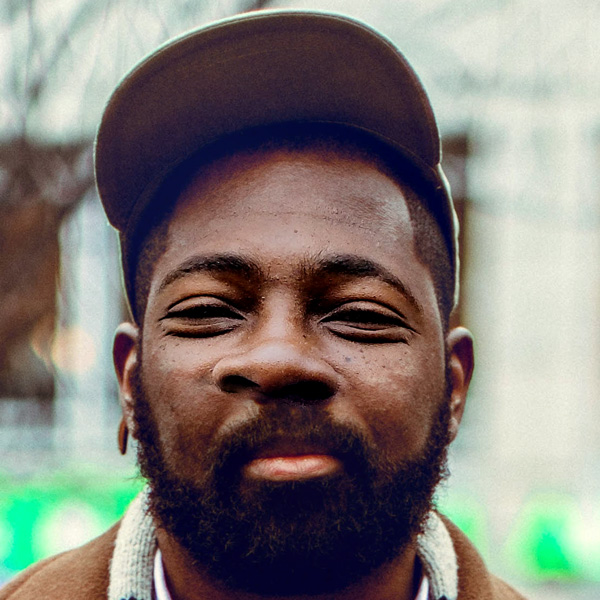

In [49]:
# take the first training image without shuffling
img = Image.open('data/real_and_fake_face/training_fake/easy_1_1110.jpg')

img

In [50]:
# recuperate the feature extractor
feature_extractor = ViTFeatureExtractor(model_name)

# recuperate the dataset
dataset = FakeFaceDetectionDataset('data/real_and_fake_face/training_fake/', 
                                   'data/real_and_fake_face/training_real/',
                                   id_map=characs['ids'], transformer=feature_extractor,
                                   transformer_kwargs={'return_tensors': 'pt'})

# load a batch of one sequence
image = next(iter(DataLoader(dataset)))

Let us provide the pixel values and labels to the model and set output attentions to <i style = "color: orange">True</i> to recuperate the attentions.

In [51]:
outputs = vit_model(image['pixel_values'][0], output_attentions = True, labels = image['labels'])

Let us recuperate the attention matrix of the last encoder layer, take that of the previous patch and calculate the mean attention over the heads.

In [52]:
# recuperate the attention of the last encoder layer attention heads
attention = outputs.attentions[-1].detach().cpu()

# recuperate the attention provided by the last patch (notice that we eliminate 1 because of the +1 added by the convolutation layer)
attention = attention[:, :, -1, 1:]

# take the attention provided by the first head
attention = attention[:, 0]

# let us recuperate the size of the original image and define patch size
pixel_values = image['pixel_values'][0]
img_size = pixel_values.shape
patch_size = 14

# let us reshape transform the image to a numpy array
img = np.array(transforms.Resize(224)(img))

# calculate the scale factor
scale_factor = img_size[3] * img_size[2] / (patch_size * patch_size)

# rescale the attention with the nearest scaler
attention = F.interpolate(attention.unsqueeze(0), scale_factor=scale_factor,
                          mode='nearest')

# let us reshape the attention to the right size
attention = attention.reshape(img_size[2], img_size[3], 1)


In [53]:
attention.min()

tensor(0.0006)

In [54]:
attention.max()

tensor(0.0285)

Let us multiply the obtained attention with the image and display the result.

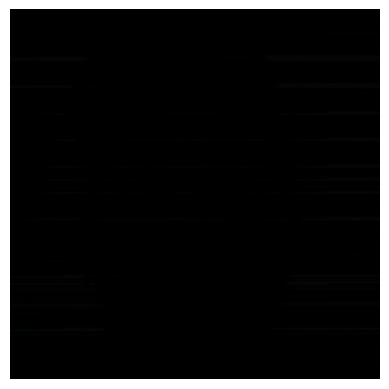

In [55]:
# recuperate the result
attention_image = img / 255 * attention.numpy() 
# attention_image = img / 255 * attention.numpy()

# visualize the result
plt.imshow(attention_image)

plt.axis('off')

plt.show()

The image must be scaled up to be correctly visualized. We must then choose a scale which will be multiplied to the image in order to obtain a more clear result. Let us take one of `50` (after experimentation).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


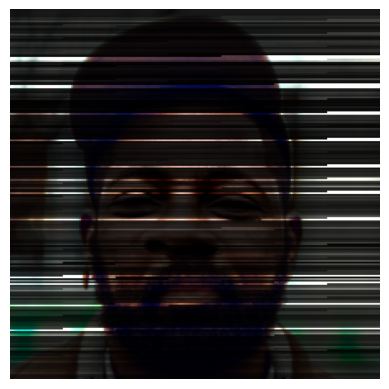

In [56]:
# define a scale
scale = 50

# recuperate the result
attention_image = img / 255 * attention.numpy() * scale
# attention_image = img / 255 * attention.numpy()

# visualize the result
plt.imshow(attention_image)

plt.axis('off')

plt.show()

We obtained the above result because we still needed to train the model on the images. Let us create in the next section a function that makes us visualize the most critical pixels in the test set's images.

### Metrics and predictions

Let us create a function to compute the `accuracy,` the `f1-score`, and the `auc` at each training iteration.

In [57]:
%%writefile fake-face-detection/fake_face_detection/metrics/compute_metrics.py

import numpy as np
import evaluate

metrics = {
    'f1': evaluate.load('f1'),
    'accuracy': evaluate.load('accuracy'),
    'roc_auc': evaluate.load('roc_auc', 'multiclass')
}

def compute_metrics(p): # some part was got from https://huggingface.co/blog/fine-tune-vit
    
    predictions, label_ids = p
    
    metric = metrics['accuracy'].compute(predictions = np.argmax(predictions, axis = 1), references=label_ids)
    
    f1_score = metrics['f1'].compute(predictions=np.argmax(predictions, axis = 1), references=label_ids)
    
    metric.update(f1_score)
    
    try:
        
        auc = metrics['roc_auc'].compute(prediction_scores=predictions, references=label_ids)
    
        metric.update(auc)
        
    except:
        
        pass
        
    return metric
    
    

Overwriting fake-face-detection/fake_face_detection/metrics/compute_metrics.py


The following function will help us obtain the predictions, and the attention will be visualized in the tensorboard.

In [63]:
%%writefile fake-face-detection/fake_face_detection/metrics/make_predictions.py

from fake_face_detection.data.fake_face_dataset import FakeFaceDetectionDataset
from fake_face_detection.metrics.compute_metrics import compute_metrics
from torch.utils.tensorboard import SummaryWriter
from PIL.JpegImagePlugin import JpegImageFile
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from typing import *
import pandas as pd
from math import *
import numpy as np
import torch
import os

def get_attention(image: Union[str, JpegImageFile], attention: torch.Tensor, size: tuple, patch_size: tuple, scale: int = 50, head: int = 1):
    
    # recuperate the image as a numpy array
    if isinstance(image, str):
        
        with Image.open(image) as img:
        
            img = np.array(transforms.Resize(size)(img))
    
    else:
        
        img = np.array(transforms.Resize(size)(image))
        
    # recuperate the attention provided by the last patch (notice that we eliminate 1 because of the +1 added by the convolutation layer)
    attention = attention[:, -1, 1:]

    # calculate the mean attention
    attention = attention[head - 1]

    # let us reshape transform the image to a numpy array

    # calculate the scale factor
    scale_factor = size[0] * size[1] / (patch_size[0] * patch_size[1])

    # rescale the attention with the nearest scaler
    attention = F.interpolate(attention.reshape(1, 1, -1), scale_factor=scale_factor,
                            mode='nearest')

    # let us reshape the attention to the right size
    attention = attention.reshape(size[0], size[1], 1)
    
    # recuperate the result
    attention_image = img / 255 * attention.numpy() * scale
    
    return np.clip(attention_image, 0, 1)


def make_predictions(test_dataset: FakeFaceDetectionDataset,
                     model,
                     log_dir: str = "fake_face_logs",
                     tag: str = "Attentions",
                     batch_size: int = 3,
                     size: tuple = (224, 224), 
                     patch_size: tuple = (14, 14),
                     figsize: tuple = (24, 24),
                     attention_scale: int = 50,
                     show: bool = True, 
                     head: int = 1):
    """Make predictions with a vision transformer model

    Args:
        test_dataset (FakeFaceDetectionDataset): The test dataset
        model (_type_): The model
        log_dir (str, optional): The log directory. Defaults to "fake_face_logs".
        tag (str, optional): The tag. Defaults to "Attentions".
        batch_size (int, optional): The batch size. Defaults to 3.
        size (tuple, optional): The size of the attention image. Defaults to (224, 224).
        patch_size (tuple, optional): The path size. Defaults to (14, 14).
        figsize (tuple, optional): The figure size. Defaults to (24, 24).
        attention_scale (int, optional): The attention scale. Defaults to 50.
        show (bool, optional): A boolean value indicating if we want to recuperate the figure. Defaults to True.
        head (int, optional): The head number. Defaults to 1.

    Returns:
        Union[Tuple[pd.DataFrame, dict], Tuple[pd.DataFame, dict, figure]]: The return prediction and the metrics
    """
    
    with torch.no_grad():
        
        _ = model.eval()
        
        # initialize the logger
        writer = SummaryWriter(os.path.join(log_dir, "attentions"))
        
        # let us recuperate the images and labels
        images = test_dataset.images
        
        labels = test_dataset.labels
        
        # let us initialize the predictions
        predictions = {'attentions': [], 'predictions': [], 'true_labels': labels, 'predicted_labels': []}

        # let us initialize the dataloader
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
        
        # get the loss
        loss = 0
        
        for data in test_dataloader:
            
            # recuperate the pixel values
            pixel_values = data['pixel_values'][0]
            
            # recuperate the labels
            labels_ = data['labels']
            
            # # recuperate the outputs
            outputs = model(pixel_values, labels = labels_, output_attentions = True)
            
            # recuperate the predictions
            predictions['predictions'].append(torch.softmax(outputs.logits.detach(), axis = -1).numpy())
            
            # recuperate the attentions of the last encoder layer
            predictions['attentions'].append(outputs.attentions[-1].detach())
            
            # add the loss
            loss += outputs.loss.detach().item()
        
        predictions['predictions'] = np.concatenate(predictions['predictions'], axis = 0)
        
        predictions['attentions'] = torch.concatenate(predictions['attentions'], axis = 0)
        
        predictions['predicted_labels'] = np.argmax(predictions['predictions'], axis = -1).tolist()
        
        # let us calculate the metrics
        metrics = compute_metrics((predictions['predictions'], np.array(predictions['true_labels'])))
        metrics['loss'] = loss / len(test_dataloader)
        
        # for each image we will visualize his attention
        nrows = ceil(sqrt(len(images)))
        
        fig, axes = plt.subplots(nrows=nrows, ncols=nrows, figsize = figsize)
        
        axes = axes.flat
        
        for i in range(len(images)):
            
            attention_image = get_attention(images[i], predictions['attentions'][i], size, patch_size)
        
            axes[i].imshow(attention_image)
            
            axes[i].set_title(f'Image {i + 1}')
            
            axes[i].axis('off')
            
        fig.tight_layout()
        
        [fig.delaxes(axes[i]) for i in range(len(images), nrows * nrows)]
        
        writer.add_figure(tag, fig)    
        
        # let us remove the predictions and the attentions
        del predictions['predictions']
        del predictions['attentions']
        
        # show the figure if necessary
        if show: return pd.DataFrame(predictions), metrics, fig
        else:
            # let us recuperate the metrics and the predictions
            return pd.DataFrame(predictions), metrics
        
        
        

Overwriting fake-face-detection/fake_face_detection/metrics/make_predictions.py


Let us make predictions on the test dataset and print the metrics.

In [64]:
%run fake-face-detection/fake_face_detection/metrics/make_predictions.py

# recuperate the test dataset 
test_dataset = FakeFaceDetectionDataset('data/real_and_fake_splits/test/training_fake/',
                                        'data/real_and_fake_splits/test/training_real/',
                                        characs['ids'],
                                        feature_extractor, transformer_kwargs={'return_tensors': 'pt'})

# recuperate the predictions
predictions, metrics, fig = make_predictions(test_dataset, vit_model.cpu())

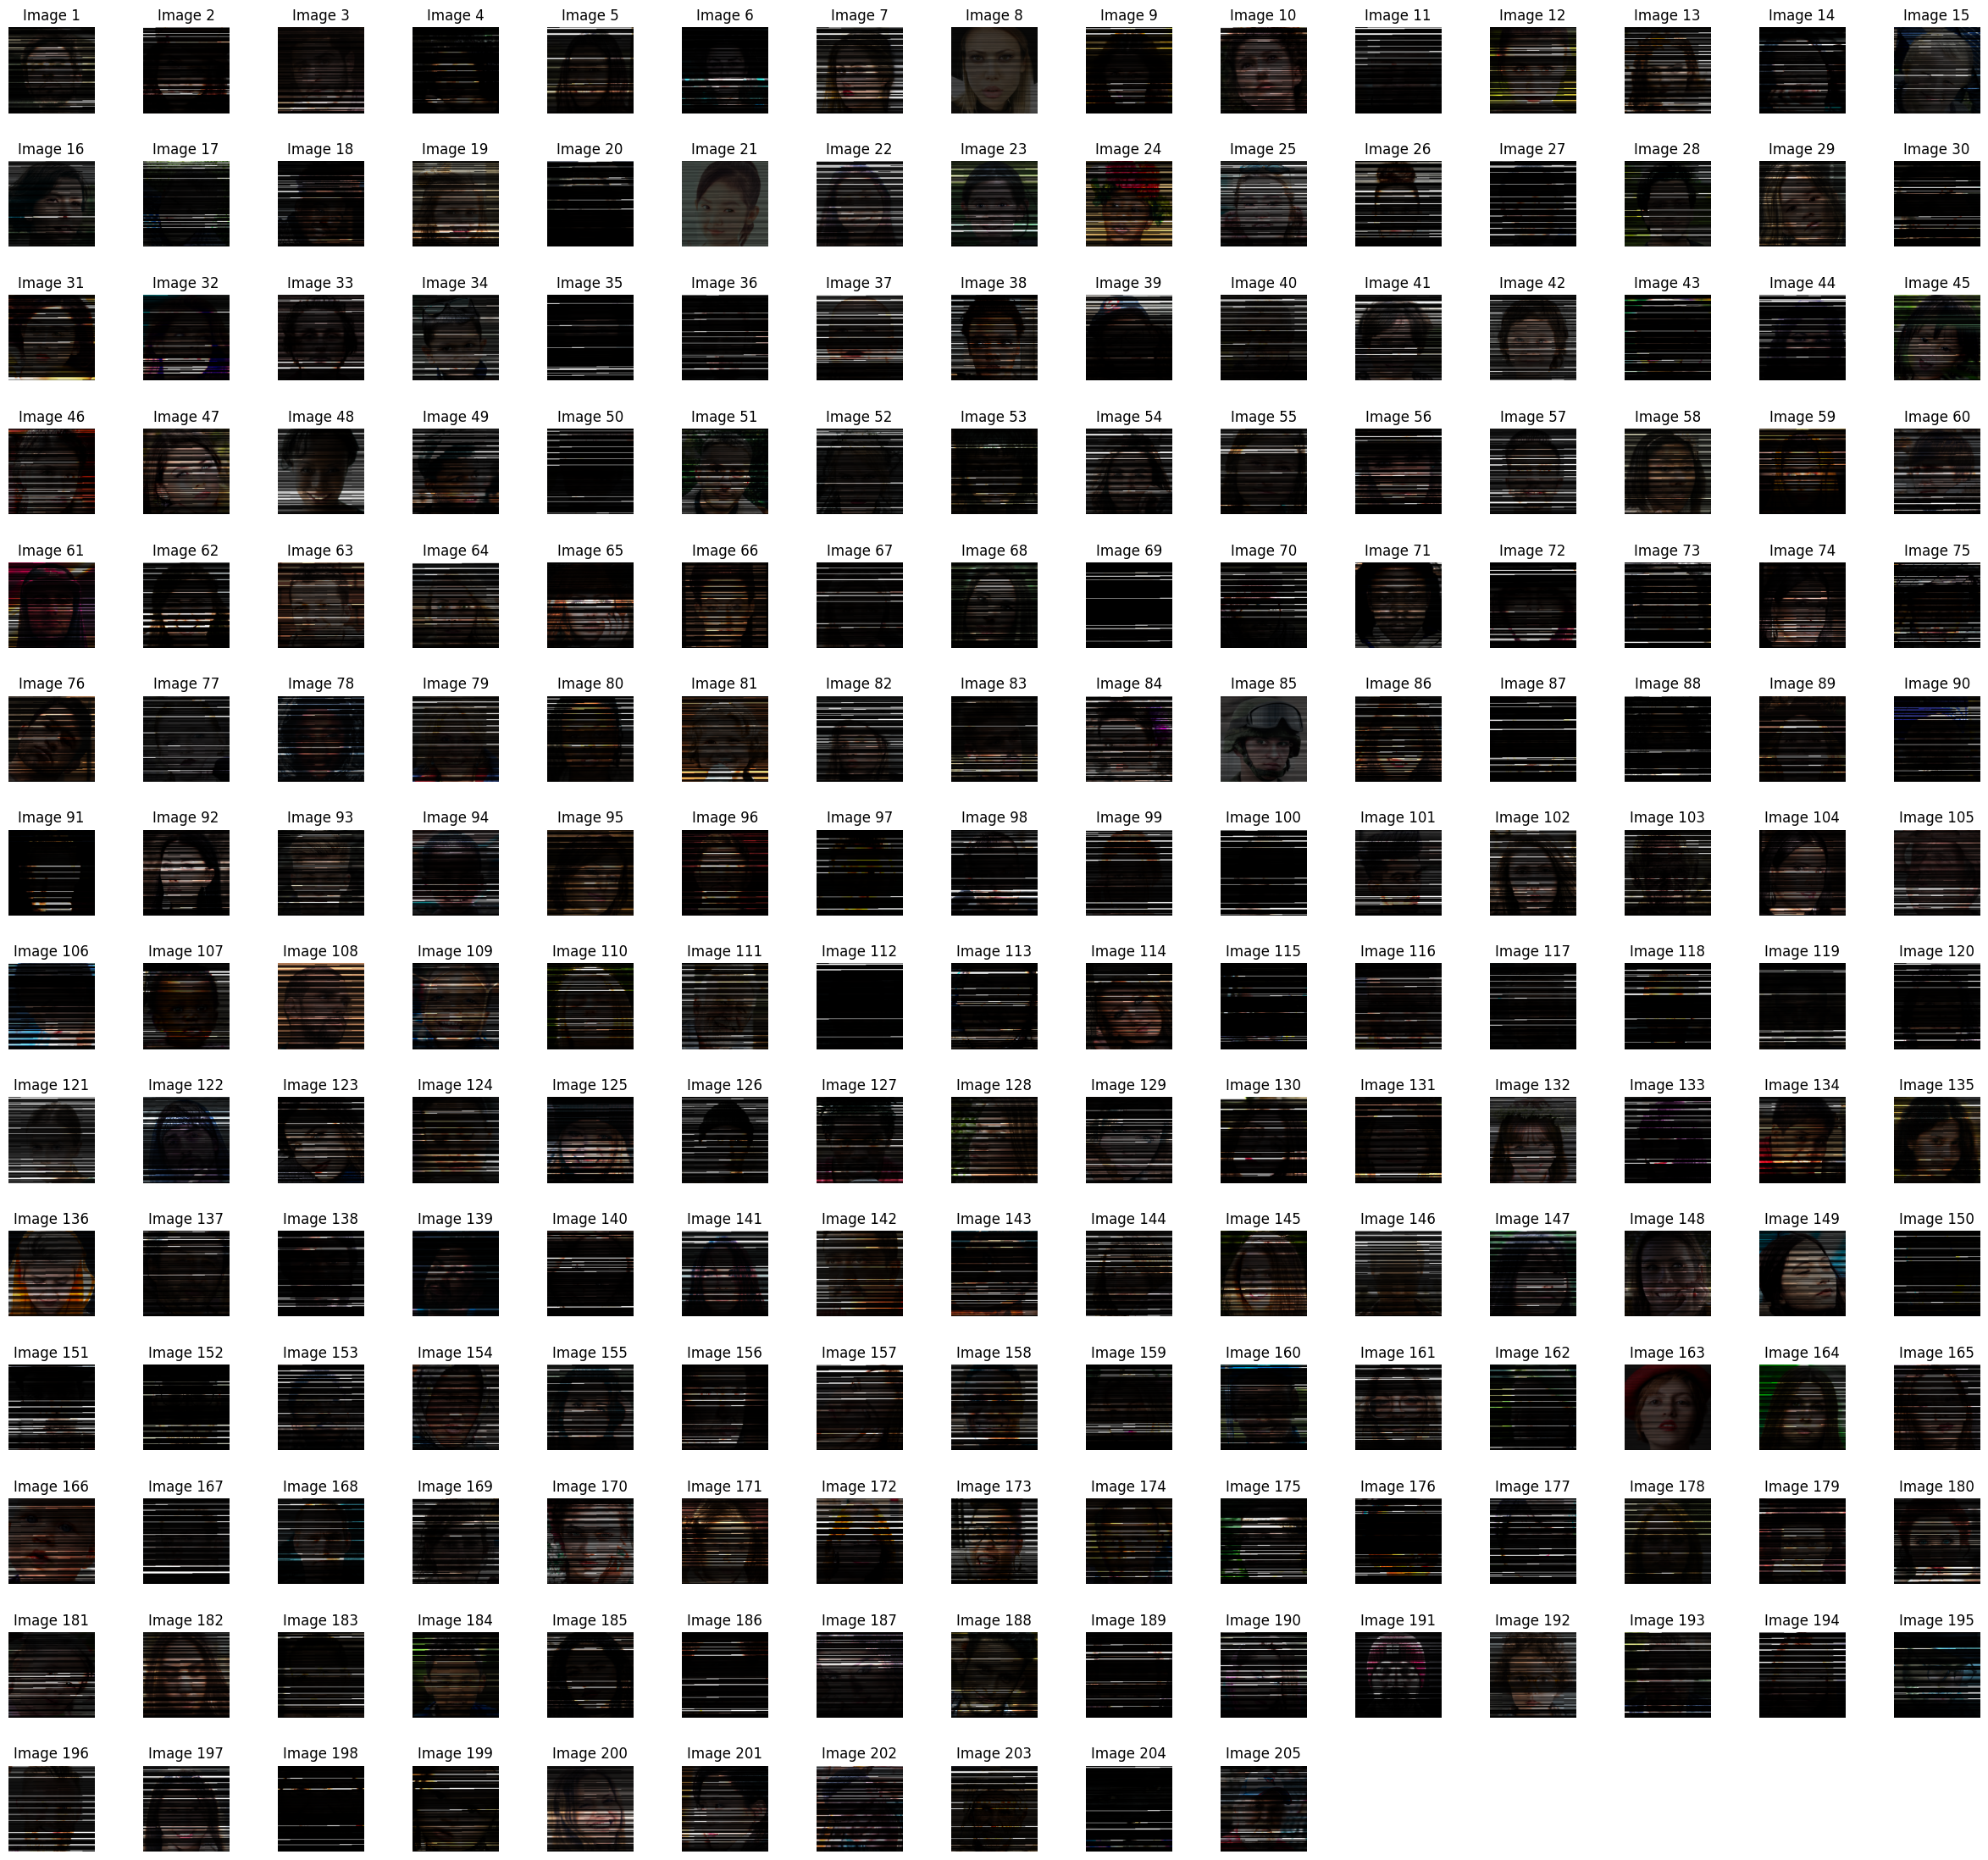

In [65]:
fig

In [66]:
predictions

,true_labels,predicted_labels
0,0,1
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
200,1,0
201,1,1
202,1,1
203,1,1


In [67]:
metrics

{'accuracy': 0.5707317073170731,
 'f1': 0.66412213740458,
 'loss': 0.6821330448855525}